In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time 
import pickle

import numpy as np
import scipy as sc
import pandas as pd
import torch

import gb1
import models
from utils import str2onehot
import utils

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

MODEL_PATH = '/data/wongfanc/gb1-models/'

2025-01-23 18:26:23.786215: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-23 18:26:23.786243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-23 18:26:23.787298: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 18:26:23.793899: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-23 18:26:25.313970: W tensorflow/comp

In [95]:
# load training sequences
fname = '/data/wongfanc/gb1-models/gb1-h10-5k-030123-train-idx.npz'
d = np.load(fname)
train_idx = d['train_idx'][: 5000]

df = pd.read_csv('../data/gb1-with-variance.csv')
seq_n = list(df['Variants'].str.lower())
y_n = df['log_fitness'].to_numpy()

trainseq_n = [seq_n[i] for i in train_idx]
ytrain_n = np.array([y_n[i] for i in train_idx])

0.8 -3.9436077044558915
0.9 -2.53016871485038
0.95 -0.7911715915478643
0.98 0.35361658488812653
0.99 0.9506659969115955


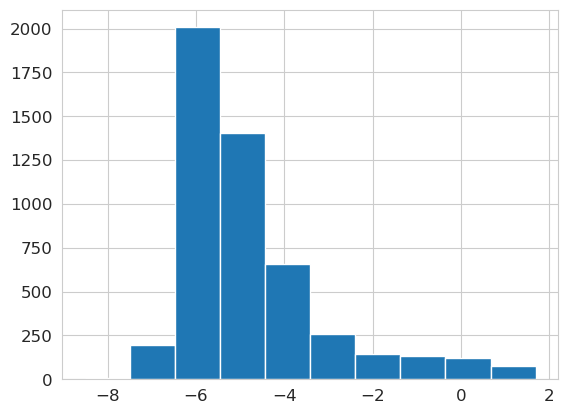

In [99]:
plt.hist(ytrain_n);
for q in [0.8, 0.9, 0.95, 0.98, 0.99]:
    print(q, np.quantile(ytrain_n, q))

One-hot encoded sequences to shape = (5000, 4, 21) (0 sec)
4500 training data points with 34.0 positive, 500 validation data points with 5.0 positive.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 188.40it/s]


Epoch 0. Train loss: 0.69. Val loss: 0.69. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 188.78it/s]


Epoch 1. Train loss: 0.65. Val loss: 0.68. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 177.96it/s]


Epoch 2. Train loss: 0.54. Val loss: 0.63. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 186.34it/s]


Epoch 3. Train loss: 0.40. Val loss: 0.52. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 176.48it/s]


Epoch 4. Train loss: 0.30. Val loss: 0.44. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 195.13it/s]


Epoch 5. Train loss: 0.21. Val loss: 0.38. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 182.11it/s]


Epoch 6. Train loss: 0.14. Val loss: 0.35. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 189.45it/s]


Epoch 7. Train loss: 0.10. Val loss: 0.33. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 192.10it/s]


Epoch 8. Train loss: 0.08. Val loss: 0.34. 0 sec.


100%|█████████████████████████████████████████████████████| 71/71 [00:00<00:00, 191.82it/s]


Epoch 9. Train loss: 0.07. Val loss: 0.37. 0 sec.


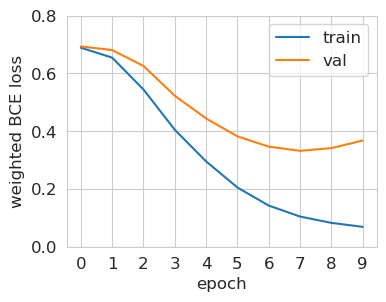

In [27]:
reload(models)
exceedance_threshold = 1.1
n_epoch = 10

predictor = models.FeedForwardClassifier(
    exceedance_threshold,
    4,
    gb1.AA,
    10,
    n_model=3,
    device=torch.device(0)
)
loss_tx2 = predictor.fit(trainseq_n, ytrain_n, n_epoch=n_epoch)

plt.figure(figsize=(4, 3))
plt.plot(loss_tx2[:, 0])
plt.plot(loss_tx2[:, 1])
plt.xticks(range(n_epoch))
plt.ylim([0, 0.8])
plt.xlabel('epoch');
plt.ylabel('weighted BCE loss');
plt.legend(['train', 'val']);

In [19]:
# load design distributions
temperatures = np.arange(0.2, 0.701, 0.005)  # np.arange(0.2, 0.701, 0.005) in 03.08 results
temp2theta = {
    round(t, 4): np.load('/data/wongfanc/gb1-models/gb1-h10-5k-t{:.4f}-030123.npz'.format(t))['theta_lxa']
    for t in temperatures
}

# true means of design distributions
# temp2mean = gb1.get_true_mean_label_from_theta(temp2theta, verbose=True)
# print('Max achievable mean label: {:.4f}'.format(np.max(list(temp2mean.values()))))

In [22]:
# oh.
np.mean(ytrain_n >= exceedance_threshold)

0.0078

In [20]:
# 12.19.24: nope not doing this with binary classifier
reload(models)
reload(gb1)

target_values = np.arange(0.0, 1.01, 0.02)
n_cal = 5000
n_trial = 500
pp_csv_fname = '/data/wongfanc/gb1-results/gb1-pp-exceed{:.4f}-121924.csv'.format(exceedance_threshold)
save_design_samples = False
load_design_samples = True

design_samples_fname_prefix = 'gb1-h10-5k-030123-samples'

df = gb1.run_pp_exceedance_selection_experiments(
    predictor,
    exceedance_threshold,
    temp2theta,
    target_values,
    n_cal=n_cal,
    n_trial=n_trial,
    pp_csv_fname=pp_csv_fname,
    design_samples_fname_prefix=design_samples_fname_prefix,
    load_design_samples=True
)

Selection quantity is probability of exceeding 1.1.
Range of provided target values: [0.000, 1.000].

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2000.npz.



KeyboardInterrupt



# 01.08.25

In [2]:
# load model
reload(models)
model = models.EnrichmentFeedForward(
    4,
    gb1.AA,
    n_hidden=10,
    n_model=3,
    device=torch.device(0)
)
model.load('gb1-h10-5k-030123')

In [3]:
# load design distributions
temperatures = np.arange(0.2, 0.701, 0.005)
temp2theta = {
    round(t, 4): np.load('/data/wongfanc/gb1-models/gb1-h10-5k-t{:.4f}-030123.npz'.format(t))['theta_lxa']
    for t in temperatures
}

In [4]:
reload(gb1)

exceedance_threshold = 1.1
target_values = np.arange(0.0, 1.01, 0.02)
n_cal = 5000
n_train_lr = 3000
n_trial = 500
n_design_subsample = 1000
pp_csv_fname = '/data/wongfanc/gb1-results/gb1-pp-exceed{:.4f}-012225.csv'.format(exceedance_threshold)
forecast_csv_fname = '/data/wongfanc/gb1-results/gb1-qc-exceed{:.4f}-012225.csv'.format(exceedance_threshold)
design_samples_fname_prefix = 'gb1-h10-5k-030123-samples'

pp_df, forecast_df = gb1.select_for_exceedance_with_calibration_data(
    model,
    temp2theta,
    target_values,
    exceedance_threshold=exceedance_threshold,
    n_cal=n_cal,
    n_trial=n_trial,
    n_train_lr=n_train_lr,
    n_design_subsample=n_design_subsample,
    pp_csv_fname=pp_csv_fname,
    forecast_csv_fname=forecast_csv_fname,
    self_normalize_weights=True,
    design_samples_fname_prefix=design_samples_fname_prefix,
    load_design_samples=True,
)

Selection quantity is probability of exceeding 1.1.
Range of provided target values: [0.000, 1.000].

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2000.npz.
Done with 500 trials for temperature 0.2000 (1 / 101) (356 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-012225.csv.
Saved CP and marginally calibrated forecasts results to /data/wongfanc/gb1-results/gb1-qc-exceed1.1000-012225.csv (359 s).

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2050.npz.
Done with 500 trials for temperature 0.2050 (2 / 101) (719 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-012225.csv.
Saved CP and marginally calibrated forecasts results to /data/wongfanc/gb1-results/gb1-qc-exceed1.1000-012225.csv (722 s).

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2100.npz.
Done with 500 trials for temperature 0.2100 (3 / 101) (10

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.3100.npz.
Done with 500 trials for temperature 0.3100 (23 / 101) (8212 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-012225.csv.
Saved CP and marginally calibrated forecasts results to /data/wongfanc/gb1-results/gb1-qc-exceed1.1000-012225.csv (8216 s).

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.3150.npz.
Done with 500 trials for temperature 0.3150 (24 / 101) (8569 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-012225.csv.
Saved CP and marginally calibrated forecasts results to /data/wongfanc/gb1-results/gb1-qc-exceed1.1000-012225.csv (8573 s).

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.3200.npz.
Done with 500 trials for temperature 0.3200 (25 / 101) (8927 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-012225.csv.
Saved CP 

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.4200.npz.
Done with 500 trials for temperature 0.4200 (45 / 101) (16089 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-012225.csv.
Saved CP and marginally calibrated forecasts results to /data/wongfanc/gb1-results/gb1-qc-exceed1.1000-012225.csv (16093 s).

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.4250.npz.
Done with 500 trials for temperature 0.4250 (46 / 101) (16447 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-012225.csv.
Saved CP and marginally calibrated forecasts results to /data/wongfanc/gb1-results/gb1-qc-exceed1.1000-012225.csv (16452 s).

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.4300.npz.
Done with 500 trials for temperature 0.4300 (47 / 101) (16806 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-012225.csv.
Save

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.5300.npz.
Done with 500 trials for temperature 0.5300 (67 / 101) (23975 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-012225.csv.
Saved CP and marginally calibrated forecasts results to /data/wongfanc/gb1-results/gb1-qc-exceed1.1000-012225.csv (23980 s).

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.5350.npz.
Done with 500 trials for temperature 0.5350 (68 / 101) (24332 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-012225.csv.
Saved CP and marginally calibrated forecasts results to /data/wongfanc/gb1-results/gb1-qc-exceed1.1000-012225.csv (24337 s).

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.5400.npz.
Done with 500 trials for temperature 0.5400 (69 / 101) (24690 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-012225.csv.
Save

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.6400.npz.
Done with 500 trials for temperature 0.6400 (89 / 101) (31869 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-012225.csv.
Saved CP and marginally calibrated forecasts results to /data/wongfanc/gb1-results/gb1-qc-exceed1.1000-012225.csv (31875 s).

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.6450.npz.
Done with 500 trials for temperature 0.6450 (90 / 101) (32226 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-012225.csv.
Saved CP and marginally calibrated forecasts results to /data/wongfanc/gb1-results/gb1-qc-exceed1.1000-012225.csv (32232 s).

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.6500.npz.
Done with 500 trials for temperature 0.6500 (91 / 101) (32584 s).
Saved PP results to /data/wongfanc/gb1-results/gb1-pp-exceed1.1000-012225.csv.
Save

In [ ]:
# try other HPs
reload(gb1)

exceedance_threshold = 1.1
target_values = np.arange(0.0, 1.01, 0.02)
n_cal = 5000
n_train_lr = 4000
n_trial = 500
n_design_subsample = 1000
pp_csv_fname = '/data/wongfanc/gb1-results/gb1-pp-exceed{:.4f}-012225-2.csv'.format(exceedance_threshold)
forecast_csv_fname = '/data/wongfanc/gb1-results/gb1-qc-exceed{:.4f}-012225-2.csv'.format(exceedance_threshold)
design_samples_fname_prefix = 'gb1-h10-5k-030123-samples'

pp_df, forecast_df = gb1.select_for_exceedance_with_calibration_data(
    model,
    temp2theta,
    target_values,
    exceedance_threshold=exceedance_threshold,
    n_cal=n_cal,
    n_trial=n_trial,
    n_train_lr=n_train_lr,
    n_design_subsample=n_design_subsample,
    pp_csv_fname=pp_csv_fname,
    forecast_csv_fname=forecast_csv_fname,
    self_normalize_weights=True,
    design_samples_fname_prefix=design_samples_fname_prefix,
    load_design_samples=True,
)

In [8]:
# compute true exceedance (only need to do once per threshold)
exceedance_threshold = 1.
temp2exceed = gb1.get_true_mean_label_from_theta(temp2theta, threshold=exceedance_threshold) 
with open('/data/wongfanc/gb1-models/h10-5k-030123-temp2exceed{}.pkl'.format(exceedance_threshold), 'wb') as f:
    pickle.dump(temp2exceed, f, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
# load true exceedances from *5k-030123* distributions
exceedance_threshold = 0.9
with open('/data/wongfanc/gb1-models/h10-5k-030123-temp2exceed{}.pkl'.format(exceedance_threshold), 'rb') as f:
    temp2exceed = pickle.load(f)

In [21]:
# process results for plotting
pp_csv_fname = '/data/wongfanc/gb1-results/gb1-pp-exceed{:.4f}-011625-2.csv'.format(exceedance_threshold)
pp_df = pd.read_csv(pp_csv_fname, index_col=0)
ppworst_v, pperr_v, ppdisc_v, ppval2temprange = utils.process_gb1_selection_experiments(
    pp_df, target_values, temperatures, temp2exceed, n_trial, imp_or_pp='pp'
)

Processing pp results with 101 temperatures in [0.200, 0.700], 51 target values in [0.00, 1.00], 500 trials, and alpha = 0.1
Done processing (58 s)


In [22]:
pp_df.head()

,tr0_pp_pval_temp0.2000,tr0_pp_pval_temp0.2050,tr0_pp_pval_temp0.2100,tr0_pp_pval_temp0.2150,tr0_pp_pval_temp0.2200,tr0_pp_pval_temp0.2250,tr0_pp_pval_temp0.2300,tr0_pp_pval_temp0.2350,tr0_pp_pval_temp0.2400,tr0_pp_pval_temp0.2450,...,tr499_pp_pval_temp0.6550,tr499_pp_pval_temp0.6600,tr499_pp_pval_temp0.6650,tr499_pp_pval_temp0.6700,tr499_pp_pval_temp0.6750,tr499_pp_pval_temp0.6800,tr499_pp_pval_temp0.6850,tr499_pp_pval_temp0.6900,tr499_pp_pval_temp0.6950,tr499_pp_pval_temp0.7000
0.00,6.043624e-12,3.783918e-14,0.014163,0.018745,0.000308,3.602871e-33,0.076345,1.650183e-28,0.000988,0.000002,...,1.967307e-11,0.281531,0.000059,0.000027,5.225483e-07,2.290794e-20,0.000014,0.000020,2.092422e-08,0.000004
0.02,1.515733e-11,1.175992e-13,0.015834,0.022201,0.000434,1.058163e-31,0.086850,1.780646e-27,0.001279,0.000003,...,1.034956e-10,0.316922,0.000149,0.000077,4.694217e-06,6.600170e-18,0.000084,0.000043,6.991669e-08,0.000013
0.04,3.735003e-11,3.574306e-13,0.017673,0.026178,0.000606,2.867912e-30,0.098399,1.834270e-26,0.001647,0.000005,...,5.120588e-10,0.354073,0.000355,0.000207,3.465417e-05,1.282703e-15,0.000434,0.000092,2.231527e-07,0.000041
0.06,9.042914e-11,1.062453e-12,0.019690,0.030735,0.000841,7.172998e-29,0.111035,1.803832e-25,0.002108,0.000007,...,2.382921e-09,0.392669,0.000804,0.000524,2.105488e-04,1.682812e-13,0.001881,0.000190,6.803904e-07,0.000126
0.08,2.151200e-10,3.088629e-12,0.021899,0.035930,0.001157,1.655656e-27,0.124792,1.693490e-24,0.002683,0.000011,...,1.043131e-08,0.432350,0.001732,0.001250,1.054830e-03,1.491764e-11,0.006856,0.000379,1.981978e-06,0.000357


In [ ]:
# load pp
pp_results_csv_fname = '/data/wongfanc/gb1-results/gb1-pp-exceed0.9000-011425-2.csv'

pp_df = pd.read_csv(pp_results_csv_fname, index_col=0)
ppworst_v, pperr_v, ppdisc_v, ppval2temprange = utils.process_gb1_selection_experiments(
    pp_df, target_values, temperatures, temp2exceed, n_trial, imp_or_pp='pp'
)

In [24]:
# load calibrated forecasts
forecast_csv_fname = '/data/wongfanc/gb1-results/gb1-qc-exceed{:.4f}-011625-2.csv'.format(exceedance_threshold)

forecast_df = pd.read_csv(forecast_csv_fname, index_col=0)
qcworst_v, qcerr_v, qcdisc_v = utils.process_gb1_cp_selection_experiments(
    forecast_df, target_values, temperatures, temp2exceed, n_trial
)

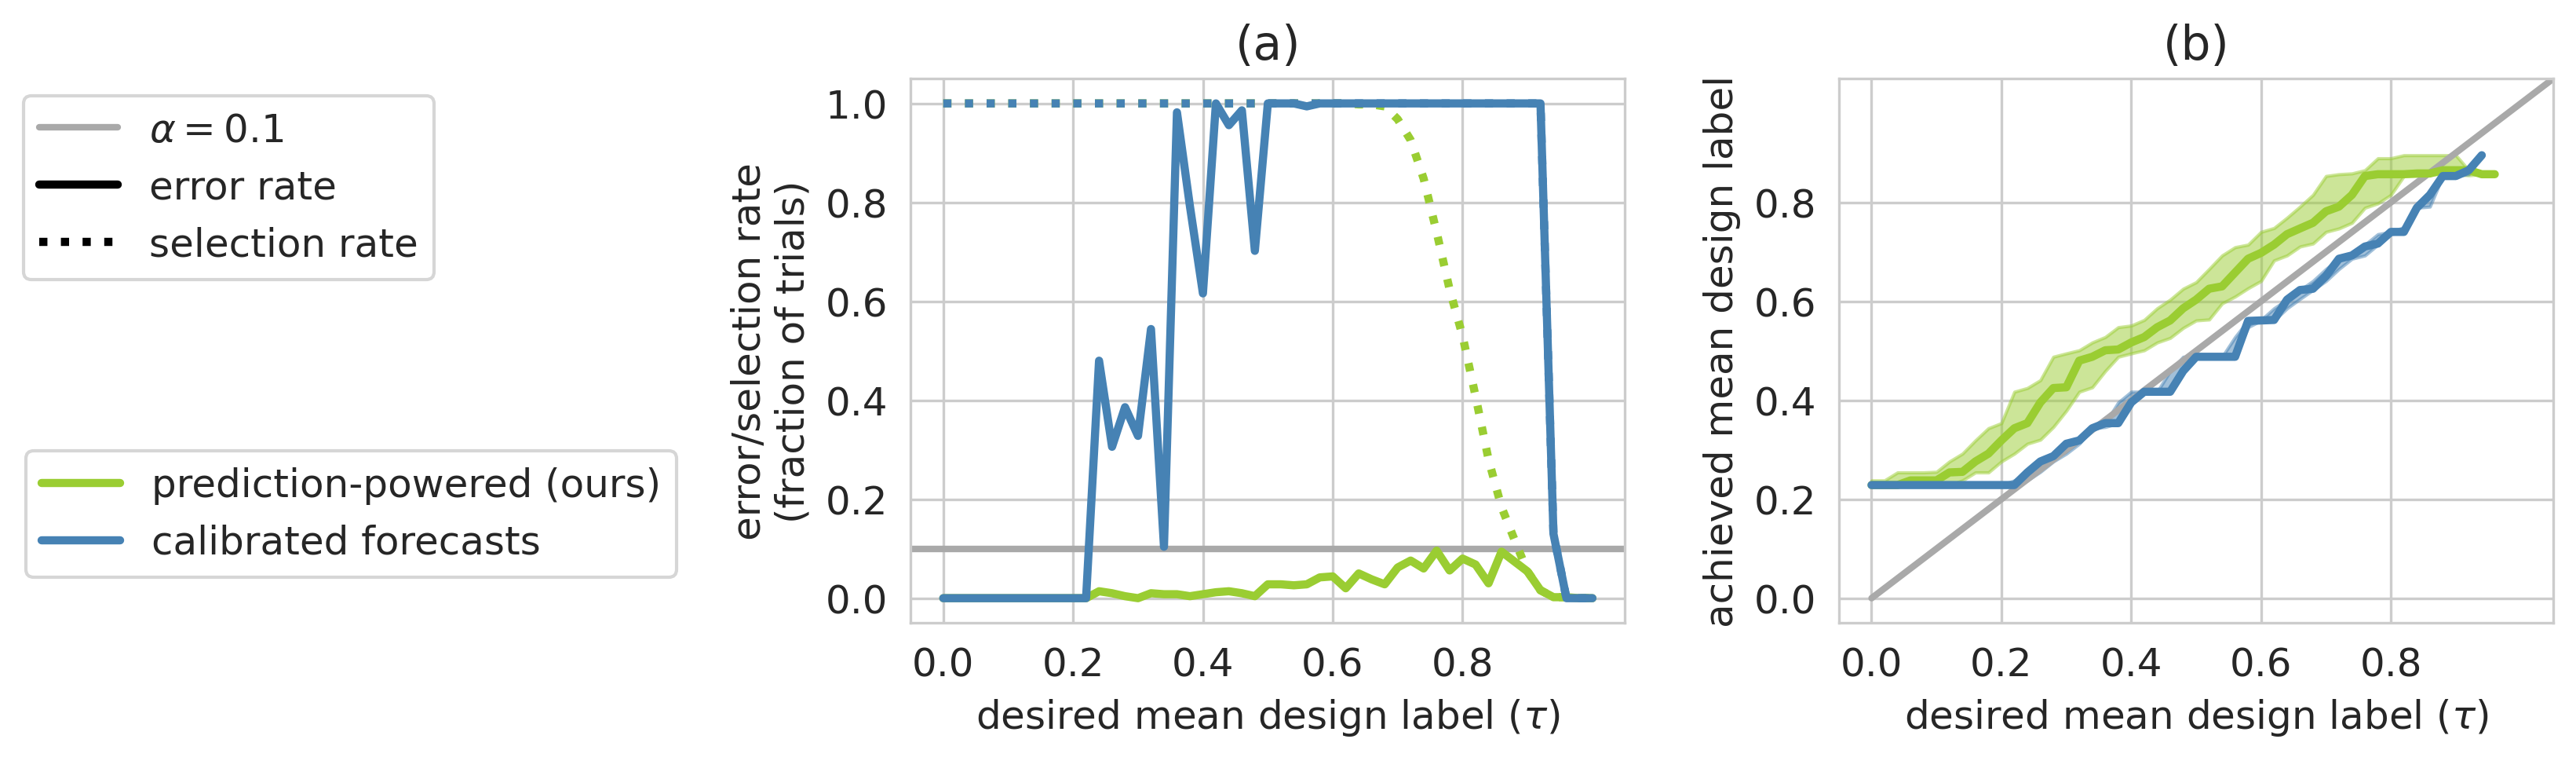

In [25]:
# one-row figure
fig, axs = plt.subplots(1, 2, figsize=(9, 3), dpi=300)
ax0 = axs[0]
ax1 = axs[1]
fig.subplots_adjust(wspace=0.3)

alpha = 0.1
pp_color = 'yellowgreen'
dark_line_color = 'darkgray'

lw = 2.5
legend_fs = 12
pp_xlim = [-0.05, 1.05]
pp_xticks = np.arange(0, 1., 0.2)

q_low = 0.2
q_high = 0.8


# ===== subplot (a) =====   
ax0.axhline(alpha, linestyle='-', color=dark_line_color, alpha=1, linewidth=2, label=r'$\alpha = {}$'.format(alpha));

ax0.plot(target_values, pperr_v, c=pp_color, linewidth=lw);
ax0.plot(target_values, ppdisc_v, ':', c=pp_color, linewidth=lw);

ax0.plot(target_values, qcerr_v, c='steelblue', linewidth=lw);
ax0.plot(target_values, qcdisc_v, ':', c='steelblue', linewidth=lw);

# dummy so get legend labels
ax0.plot(-1, -1, linestyle='-', color='k', linewidth=lw, label='error rate')
ax0.plot(-1, -1, linestyle=':', color='k', linewidth=lw, label='selection rate')

ax0.set_ylim([-0.05, 1.05])
ax0.set_yticks(np.arange(0, 1.05, 0.2))
ax0.set_xlim(pp_xlim)
ax0.set_xticks(pp_xticks)
ax0.set_ylabel('error/selection rate\n(fraction of trials)');
ax0.set_xlabel(r'desired mean design label ($\tau$)');
ax0.set_title('(a)')
ax0.legend(fontsize=legend_fs, loc='center left', bbox_to_anchor=(-1.27, 0.8))


# ===== subplot (b) =====

ax1.plot([0, 1.5], [0, 1.5], '-', c=dark_line_color, alpha=1, linewidth=2);

ax1.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in ppworst_v],
    c=pp_color, label='prediction-powered (ours)', linewidth=lw,
)
ax1.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)

ax1.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in qcworst_v],
    c='steelblue', label='calibrated forecasts', linewidth=lw,
)
ax1.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in qcworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in qcworst_v],
    color='steelblue', alpha=0.5,
)

ax1.set_xlim(pp_xlim)
ax1.set_ylim(pp_xlim)
ax1.set_xticks(pp_xticks)
ax1.set_yticks(pp_xticks)
legend = ax1.legend(fontsize=legend_fs, loc='center right', bbox_to_anchor=(-1.6, 0.2))

ax1.set_title('(b)')
ax1.set_ylabel('achieved mean design label');
ax1.set_xlabel(r'desired mean design label ($\tau$)');


# debug 

In [2]:
# load model
reload(models)
model = models.EnrichmentFeedForward(
    4,
    gb1.AA,
    n_hidden=10,
    n_model=3,
    device=torch.device(0)
)
model.load('gb1-h10-5k-030123')

In [3]:
# load design distributions
temperatures = np.arange(0.2, 0.701, 0.005)  # np.arange(0.2, 0.701, 0.005) in 03.08 results
temp2theta = {
    round(t, 4): np.load('/data/wongfanc/gb1-models/gb1-h10-5k-t{:.4f}-030123.npz'.format(t))['theta_lxa']
    for t in temperatures
}

In [4]:
exceedance_threshold = 1.1
temp2mean = gb1.get_true_mean_label_from_theta(temp2theta, threshold=exceedance_threshold, verbose=True) 
# temp2mean = gb1.get_true_mean_label_from_theta(temp2theta, threshold=None, verbose=True) 

True mean for temperature...
    0.2000 is 0.8009. (0 sec)
    0.2050 is 0.7384. (1 sec)
    0.2100 is 0.6170. (1 sec)
    0.2150 is 0.6894. (1 sec)
    0.2200 is 0.7320. (2 sec)
    0.2250 is 0.7383. (2 sec)
    0.2300 is 0.6774. (2 sec)
    0.2350 is 0.7301. (2 sec)
    0.2400 is 0.7925. (3 sec)
    0.2450 is 0.6814. (3 sec)
    0.2500 is 0.6691. (3 sec)
    0.2550 is 0.7817. (4 sec)
    0.2600 is 0.5923. (4 sec)
    0.2650 is 0.5972. (4 sec)
    0.2700 is 0.6114. (5 sec)
    0.2750 is 0.7465. (5 sec)
    0.2800 is 0.3547. (5 sec)
    0.2850 is 0.7171. (6 sec)
    0.2900 is 0.6855. (6 sec)
    0.2950 is 0.6106. (6 sec)
    0.3000 is 0.6728. (7 sec)
    0.3050 is 0.6887. (7 sec)
    0.3100 is 0.6568. (7 sec)
    0.3150 is 0.6497. (8 sec)
    0.3200 is 0.6764. (8 sec)
    0.3250 is 0.6622. (8 sec)
    0.3300 is 0.6652. (8 sec)
    0.3350 is 0.4225. (9 sec)
    0.3400 is 0.6593. (9 sec)
    0.3450 is 0.6312. (9 sec)
    0.3500 is 0.6273. (10 sec)
    0.3550 is 0.6183. (10 sec)
    0.360

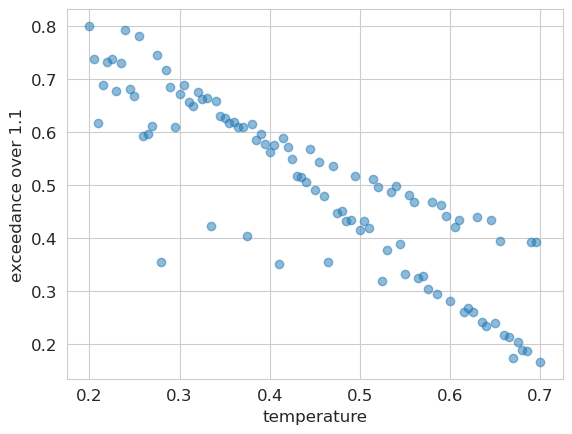

In [10]:
temps, exceeds = zip(*list(temp2mean.items()))
plt.scatter(temps, exceeds, alpha=0.5);
plt.xlabel('temperature'); plt.ylabel('exceedance over {}'.format(exceedance_threshold));

In [15]:
n_cal = 8000
n_train_lr = 3000
self_normalize_weights = True

temp2imppp = {}

for temp, theta_lxa in temp2theta.items():
    d = np.load('/data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t{:.4f}.npz'.format(temp))
    designohe_nxlxa = d['designohe_nxlxa']

    # sample calibration data from NNK
    _, allcalohe_nxlxa, allcalseq_n = gb1.sample_ohe_from_nuc_distribution(
        gb1.PNUC_NNK_LXA, n_cal, normalize=False, reject_stop_codon=True
    )
    yallcal_n = np.array([gb1.SEQ2YVAR[seq][0] for seq in allcalseq_n])
    yallcal_n = (yallcal_n >= exceedance_threshold).astype(float)

    # ----- train exceedance predictor for this trial -----
    predictor = models.ExceedancePredictor(model, exceedance_threshold)
    sampled_both_labels = False
    while not sampled_both_labels:  
        shuffle_idx = np.random.permutation(n_cal)
        train_idx, cal_idx = shuffle_idx[: n_train_lr], shuffle_idx[n_train_lr :]
        sampled_both_labels = np.sum(ycal_n[train_idx]) > 10 and np.sum(ycal_n[cal_idx]) > 10

    # print(np.sum(ycal_n[train_idx]), np.sum(ycal_n[cal_idx]))
    trainohe_nxlxa = allcalohe_nxlxa[train_idx]
    ytrain_n = yallcal_n[train_idx]
    predictor.fit(trainohe_nxlxa, ytrain_n)

    # use the remaining data for calibration
    calohe_nxlxa = allcalohe_nxlxa[cal_idx]
    ycal_n = yallcal_n[cal_idx]

    # ----- predictions -----
    # for design sequences
    preddesign_n = predictor.predict(designohe_nxlxa)
    imputed_mean = np.mean(preddesign_n)
    imputed_se = np.std(preddesign_n) / np.sqrt(preddesign_n.size)

    # for calibration sequences
    predcal_n = predictor.predict(calohe_nxlxa)

    # ----- compute rectifier -----
    # density ratios on calibration sequences
    callogptrain_n = gb1.get_nostop_loglikelihood(calohe_nxlxa, gb1.PAA_NNK_LXA)
    caldr_n = gb1.get_density_ratios(calohe_nxlxa, theta_lxa, logptrain_n=callogptrain_n)
    # cal_ess = np.square(np.sum(caldr_n)) / np.sum(np.square(caldr_n))
    if self_normalize_weights:
        caldr_n = caldr_n / np.sum(caldr_n) * caldr_n.size

    # rectifier sample mean and standard error
    rect_n = caldr_n * (ycal_n - predcal_n)
    rectifier_mean = np.mean(rect_n)
    rectifier_se = np.std(rect_n) / np.sqrt(rect_n.size)
    temp2imppp[temp] = imputed_mean, imputed_mean + rectifier_mean
    print('temp {}, true {:.3f}, PO {:.3f}, PP {:.3f}'.format(temp, temp2mean[temp], imputed_mean, imputed_mean + rectifier_mean))
    
    

temp 0.2, true 0.801, PO 0.759, PP 0.713
temp 0.205, true 0.738, PO 0.775, PP 0.903
temp 0.21, true 0.617, PO 0.471, PP 0.142
temp 0.215, true 0.689, PO 0.676, PP 0.405
temp 0.22, true 0.732, PO 0.847, PP 0.883
temp 0.225, true 0.738, PO 0.695, PP 0.844
temp 0.23, true 0.677, PO 0.644, PP -0.162
temp 0.235, true 0.730, PO 0.841, PP 0.944
temp 0.24, true 0.792, PO 0.702, PP 1.158
temp 0.245, true 0.681, PO 0.517, PP 0.763
temp 0.25, true 0.669, PO 0.441, PP 0.390
temp 0.255, true 0.782, PO 0.708, PP 0.668
temp 0.26, true 0.592, PO 0.385, PP 0.736
temp 0.265, true 0.597, PO 0.353, PP 0.773
temp 0.27, true 0.611, PO 0.696, PP 0.587
temp 0.275, true 0.747, PO 0.802, PP 0.814
temp 0.28, true 0.355, PO 0.462, PP 0.634
temp 0.285, true 0.717, PO 0.503, PP 0.742
temp 0.29, true 0.685, PO 0.748, PP 0.757
temp 0.295, true 0.611, PO 0.476, PP 0.722
temp 0.3, true 0.673, PO 0.712, PP 0.650
temp 0.305, true 0.689, PO 0.584, PP 0.691
temp 0.31, true 0.657, PO 0.674, PP 0.813
temp 0.315, true 0.650, 

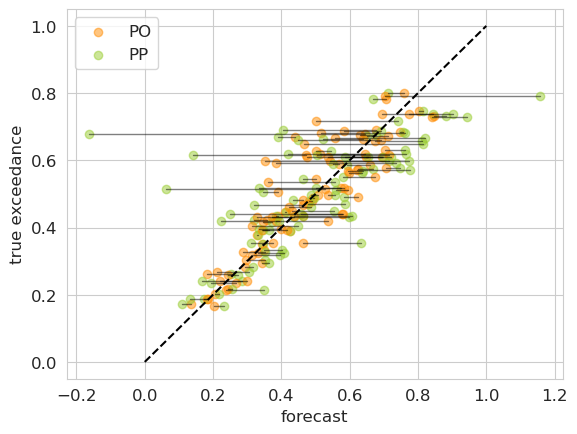

In [19]:
for temp, imp_pp in temp2imppp.items():
    plt.scatter(imp_pp[0], temp2mean[temp], c='darkorange', alpha=0.5);
    plt.scatter(imp_pp[1], temp2mean[temp], c='yellowgreen', alpha=0.5);
    
plt.plot([0, 1], [0, 1], '--k')
plt.xlabel('forecast'); plt.ylabel('true exceedance');
plt.legend(['PO', 'PP']);

In [148]:
reload(models)
# look at specific temperature
temp = 0.3000
n_cal = 100000
n_train_lr = 10000
self_normalize_weights = True

theta_lxa = temp2theta[temp]
d = np.load('/data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t{:.4f}.npz'.format(temp))
designohe_nxlxa = d['designohe_nxlxa']

# sample calibration data from NNK
_, calohe_nxlxa, calseq_n = gb1.sample_ohe_from_nuc_distribution(
    gb1.PNUC_NNK_LXA, n_cal, normalize=False, reject_stop_codon=True
)
ycal_n = np.array([gb1.SEQ2YVAR[seq][0] for seq in calseq_n])
ycal_n = (ycal_n >= exceedance_threshold).astype(float)


# ===== try exceedance predictor w/o training =====
predictor = models.ExceedancePredictor(model, exceedance_threshold)
predcal_n = predictor.predict(calohe_nxlxa)

# density ratios on calibration sequences
callogptrain_n = gb1.get_nostop_loglikelihood(calohe_nxlxa, gb1.PAA_NNK_LXA)
caldr_n = gb1.get_density_ratios(calohe_nxlxa, theta_lxa, logptrain_n=callogptrain_n)
if self_normalize_weights:
    caldr_n = caldr_n / np.sum(caldr_n) * caldr_n.size

# rectifier sample mean and standard error
rect_n = caldr_n * (ycal_n - predcal_n)
rectifier_mean = np.mean(rect_n)
print('w/o training exceedance predictor, rectifier mean = {:.3f}'.format(rectifier_mean))

# ----- predictions -----
# for design sequences
preddesign_n = predictor.predict(designohe_nxlxa)
imputed_mean = np.mean(preddesign_n)
imputed_se = np.std(preddesign_n) / np.sqrt(preddesign_n.size)

# ----- compute rectifier -----

rectifier_se = np.std(rect_n) / np.sqrt(rect_n.size)
print(' temp {}, true {:.3f}, PO {:.3f}, PP {:.3f}, |true - PP| {:.3f}'.format(
    temp, temp2mean[temp],
    imputed_mean, imputed_mean + rectifier_mean, np.abs(temp2mean[temp] - (imputed_mean + rectifier_mean))
))


# ===== try training =====
predictor = models.ExceedancePredictor(model, exceedance_threshold)
sampled_both_labels = False
while not sampled_both_labels:  
    shuffle_idx = np.random.permutation(n_cal)
    train_idx, cal_idx = shuffle_idx[: n_train_lr], shuffle_idx[n_train_lr :]
    sampled_both_labels = np.sum(ycal_n[train_idx]) > 5 and np.sum(ycal_n[cal_idx]) > 5

print('\n{} positive labels in train, {} in cal'.format(np.sum(ycal_n[train_idx]), np.sum(ycal_n[cal_idx])))
trainohe_nxlxa, ytrain_n = calohe_nxlxa[train_idx], ycal_n[train_idx]
# trainlogptrain_n = gb1.get_nostop_loglikelihood(trainohe_nxlxa, gb1.PAA_NNK_LXA)
# traindr_n = gb1.get_density_ratios(trainohe_nxlxa, theta_lxa, logptrain_n=trainlogptrain_n)
# if self_normalize_weights:
#     traindr_n = traindr_n / np.sum(traindr_n) * traindr_n.size
traindr_n = None
predictor.fit(trainohe_nxlxa, ytrain_n, weight_n=traindr_n)

# use the remaining data for calibration
calohe_nxlxa = calohe_nxlxa[cal_idx]
ycal_n = ycal_n[cal_idx]
predcal_n = predictor.predict(calohe_nxlxa)

callogptrain_n = gb1.get_nostop_loglikelihood(calohe_nxlxa, gb1.PAA_NNK_LXA)
caldr_n = gb1.get_density_ratios(calohe_nxlxa, theta_lxa, logptrain_n=callogptrain_n)
if self_normalize_weights:
    caldr_n = caldr_n / np.sum(caldr_n) * caldr_n.size

rect_n = caldr_n * (ycal_n - predcal_n)
rectifier_mean = np.mean(rect_n)
print('w/ training exceedance predictor, rectifier mean = {:.3f}'.format(rectifier_mean))

# ----- predictions -----
# for design sequences
preddesign_n = predictor.predict(designohe_nxlxa)
imputed_mean = np.mean(preddesign_n)
imputed_se = np.std(preddesign_n) / np.sqrt(preddesign_n.size)

# ----- compute rectifier -----

rectifier_se = np.std(rect_n) / np.sqrt(rect_n.size)
print('temp {}, true {:.3f}, PO {:.3f}, PP {:.3f}, |true - PP| {:.3f}'.format(
    temp, temp2mean[temp],
    imputed_mean,
    imputed_mean + rectifier_mean,
    np.abs(temp2mean[temp] - (imputed_mean + rectifier_mean))
))


w/o training exceedance predictor, rectifier mean = -0.046
 temp 0.3, true 0.673, PO 0.762, PP 0.716, |true - PP| 0.043

65.0 positive labels in train, 564.0 in cal
w/ training exceedance predictor, rectifier mean = 0.167
temp 0.3, true 0.673, PO 0.551, PP 0.718, |true - PP| 0.045


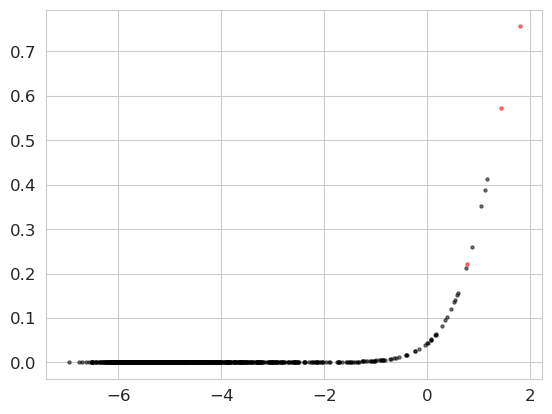

In [149]:
n_cal_to_plot = 1000
realpredcal_n = model.predict(calohe_nxlxa)
for realpred, pred, y in zip(realpredcal_n[: n_cal_to_plot], predcal_n[: n_cal_to_plot], ycal_n[: n_cal_to_plot]):
    plt.scatter(realpred, pred, alpha=0.5, s=5, c='red' if y else 'k')

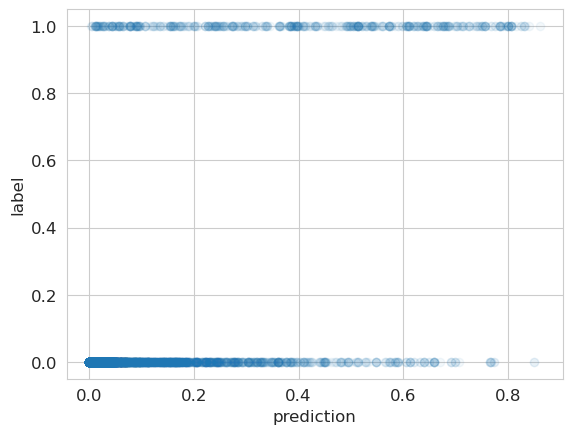

In [150]:
plt.scatter(predcal_n, ycal_n, alpha=0.05);
plt.xlabel('prediction'); plt.ylabel('label');